In [1]:
from astropy.table import Table,join
import astropy.io.fits as pyfits
import numpy as np

import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

%matplotlib inline

plt.rc('font',**{'family':'serif','size':22})
plt.rc('text', usetex=True)

In [2]:
# load the file we made (yours will be the combined fits files of the subpieces you ran)
t = Table.read("DES_DF_COSMOS_sbi_output_part5.fits")

# We should apply the cross match with the masked cat before doing this.
t2 = Table.read("COSMOS_masked_cat.fits")
t = join(t,t2,keys='id')

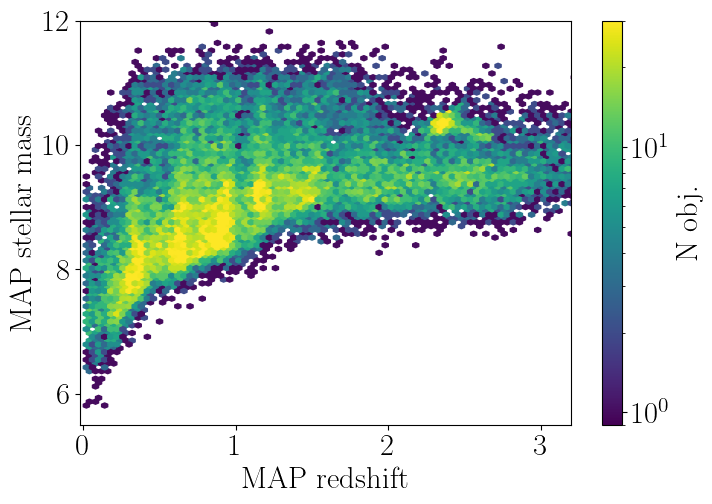

In [3]:
# plot the mode redshift and stellar mass values
fig = plt.figure(figsize=(7.5,5.5))
ax = fig.add_subplot(111)
s = ax.hexbin(t['mode_z'], t['mode_mass'], extent=(0,4,5.5,12.5), bins=50,
         norm=colors.LogNorm(vmin=0.9, vmax=30))
ax.set_xlim([-0.02,3.2])
ax.set_ylim([5.5,12.])
ax.set_xlabel(r'MAP redshift')
ax.set_ylabel(r'MAP stellar mass')
plt.tight_layout()
plt.colorbar(s, label='N obj.')
#plt.savefig("zM_SBI_output.png")
plt.show()

In [4]:
# the individual pdfs are actually histograms of samples from the posterior
# in the code we used to make these files you can see the bins we used for the histogram
# np.arange(0,5.505,0.005)
z_edges = np.arange(0,5.505,0.005)

# for the n(z), we will use the mid-point of each bin,
z_mid = (z_edges[:-1] + z_edges[1:])/2.

In [5]:
# Let's pick a sample
subsample = np.where((t['mode_z']>=0.5)&(t['mode_z']<0.8)&(t['mode_mass']>=10.5)&(t['mode_mass']<12.5))[0]

# we build the n(z) from the z_pdf column
nz_arr = np.average(t['z_pdf'][subsample,:], axis=0)

# using the average should ensure that the output n(z) is correctly normalised, but we can make sure
nz_arr = nz_arr / np.trapz(nz_arr, x=z_mid)

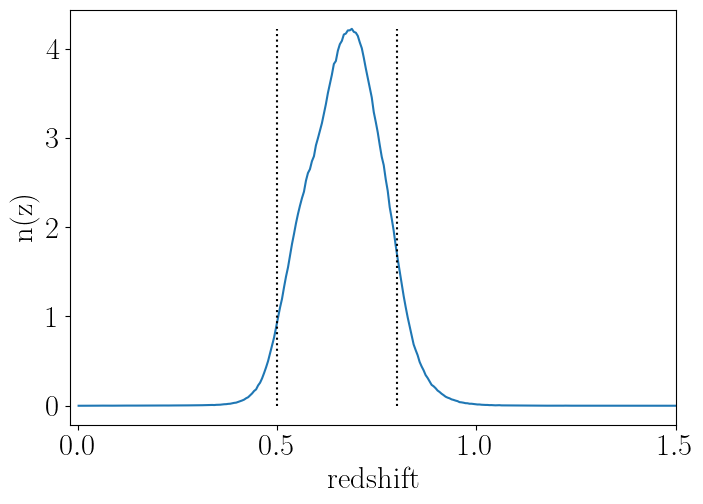

In [6]:
# plot the distribution to see what it looks like
fig = plt.figure(figsize=(7.5,5.5))
ax = fig.add_subplot(111)
ax.plot(z_mid, nz_arr, '-')
# add the tophat limits we've been using to see how it differs
ax.plot([0.5]*2, [0,np.max(nz_arr)], 'k:')
ax.plot([0.8]*2, [0,np.max(nz_arr)], 'k:')
ax.set_xlim([-0.02,1.5])
ax.set_xlabel(r'redshift')
ax.set_ylabel(r'n(z)')
plt.tight_layout()
#plt.savefig("zM_DESI_newref.png")
plt.show()


In [7]:
# to use this as an n(z) in halomod, we need to make it a 'callable' - that is a function of some sort that
# takes z as an argument and returns the galaxy number density.
# we'll use scipy's 1-d interpolation
from scipy.interpolate import interp1d
# we don't want it to crash if we try to access a value outside of our redshift range, instead we'll set such values to 0.
nz = interp1d(z_mid, nz_arr, bounds_error=False, fill_value=0)

# so now we can give it any value that halomod might like to use when performing its integration,
print(nz(0.52752))

1.550058589458463


In [8]:
# next, we'll see if we can actually use this in halomod
import halomod as hm

gg = hm.integrate_corr.AngularCF(nz, nz, p_of_z=True, zmin=0., zmax=1.5, z=0.65)
gg.hod_params = {"M_min":12.3, "M_1": 13., "alpha":1., "central": True}
gg.theta_min = 0.0002*np.pi/180
gg.theta_max = 8.*np.pi/180
gg.theta_num = 50

/home/will/anaconda3/envs/hod/lib/python3.12/site-packages/halomod/halo_exclusion.py:18: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  warnings.warn(


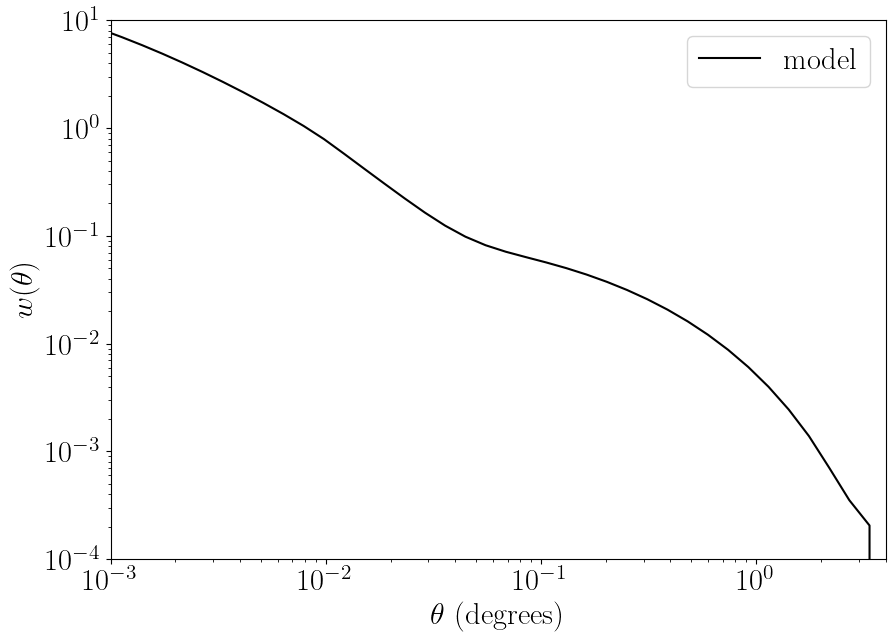

In [9]:
# and plot an example
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
ax.plot(gg.theta*180/np.pi, gg.angular_corr_gal, 'k-', label='model')
ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_ylabel(r'$w(\theta)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,10.])
ax.set_xlim([1e-3,4.])
ax.legend()
plt.show()
# I didn't realise that halomod truncates the correlation function, but it doesn't matter for this project

In [10]:
# now let's compare the clustering strength with the tophat selection function
nz2 = hm.integrate_corr.flat_z_dist(0.5,0.8)
gg2 = hm.integrate_corr.AngularCF(nz2, nz2, p_of_z=True, zmin=0., zmax=1.5, z=0.65)
gg2.hod_params = {"M_min":12.3, "M_1": 13., "alpha":1., "central": True}
gg2.theta_min = 0.0002*np.pi/180
gg2.theta_max = 8.*np.pi/180
gg2.theta_num = 50

/home/will/anaconda3/envs/hod/lib/python3.12/site-packages/halomod/integrate_corr.py:483: UserWarning: Filter function p(x) did not integrate to 1 (1.01010101010101). Tentatively re-normalising.
  warnings.warn(


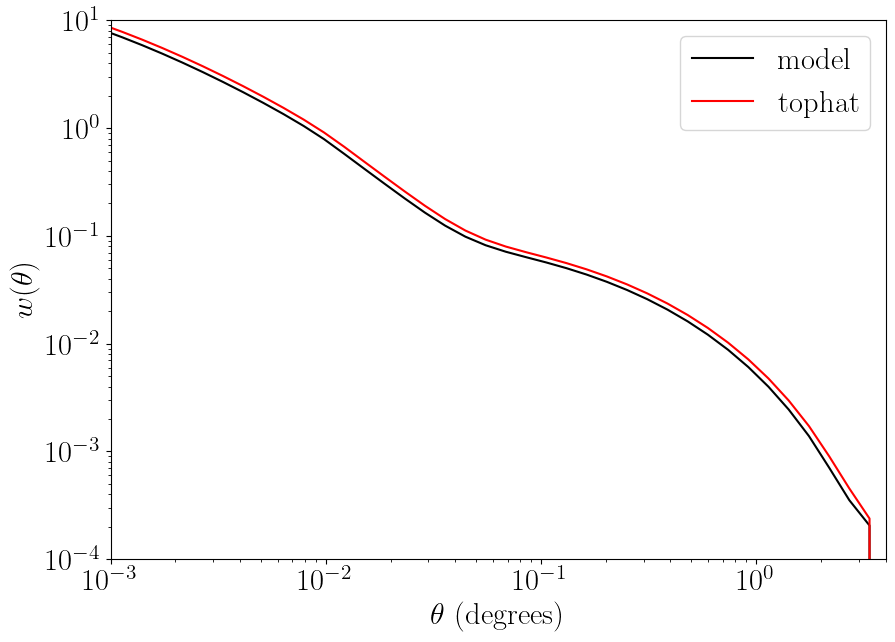

In [11]:
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
ax.plot(gg.theta*180/np.pi, gg.angular_corr_gal, 'k-', label='model')
ax.plot(gg2.theta*180/np.pi, gg2.angular_corr_gal, 'r-', label='tophat')
ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_ylabel(r'$w(\theta)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,10.])
ax.set_xlim([1e-3,4.])
ax.legend()
plt.show()
# That is actually a smaller difference than I expected!
# Note that lower stellar masses (fainter galaxies) will have larger uncertainties and so the 
# difference between the model with n(z) and tophat will be greater).

In [12]:
# If we try a narrower bin, 0.7 < z < 0.8, you can see how much more important the extra width coming from the
# redshift uncertainties is.
subsample = np.where((t['mode_z']>=0.7)&(t['mode_z']<0.8)&(t['mode_mass']>=10.5)&(t['mode_mass']<12.5))[0]
nz_arr = np.average(t['z_pdf'][subsample,:], axis=0)
nz_arr = nz_arr / np.trapz(nz_arr, x=z_mid)
nz = interp1d(z_mid, nz_arr, bounds_error=False, fill_value=0)

gg = hm.integrate_corr.AngularCF(nz, nz, p_of_z=True, zmin=0., zmax=1.5, z=0.75)
gg.hod_params = {"M_min":12.3, "M_1": 13., "alpha":1., "central": True}
gg.theta_min = 0.0002*np.pi/180
gg.theta_max = 8.*np.pi/180
gg.theta_num = 50

nz2 = hm.integrate_corr.flat_z_dist(0.7,0.8)
gg2 = hm.integrate_corr.AngularCF(nz2, nz2, p_of_z=True, zmin=0., zmax=1.5, z=0.75)
gg2.hod_params = {"M_min":12.3, "M_1": 13., "alpha":1., "central": True}
gg2.theta_min = 0.0002*np.pi/180
gg2.theta_max = 8.*np.pi/180
gg2.theta_num = 50

/home/will/anaconda3/envs/hod/lib/python3.12/site-packages/halomod/integrate_corr.py:483: UserWarning: Filter function p(x) did not integrate to 1 (0.9090909090909081). Tentatively re-normalising.
  warnings.warn(


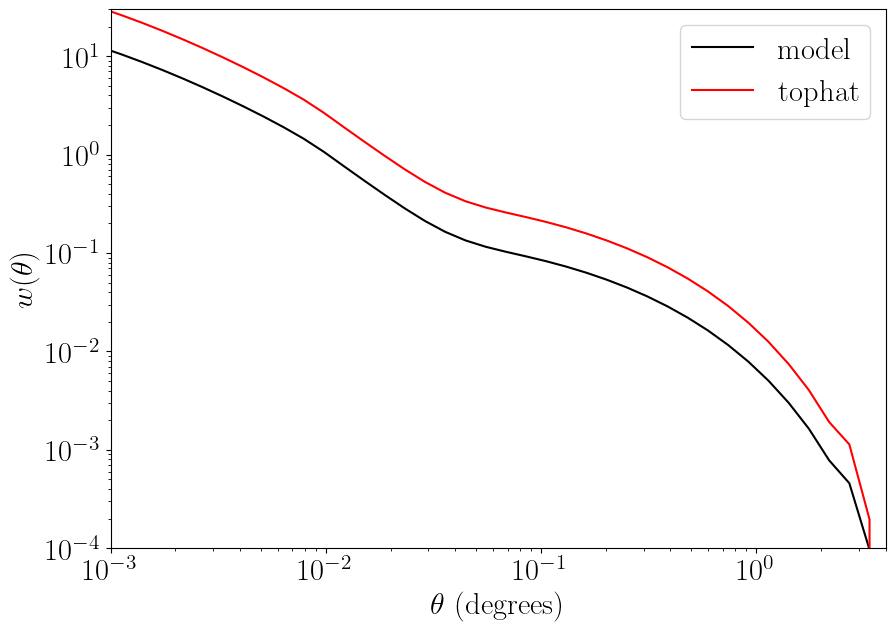

In [13]:
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
ax.plot(gg.theta*180/np.pi, gg.angular_corr_gal, 'k-', label='model')
ax.plot(gg2.theta*180/np.pi, gg2.angular_corr_gal, 'r-', label='tophat')
ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_ylabel(r'$w(\theta)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,30.])
ax.set_xlim([1e-3,4.])
ax.legend()
plt.show()